In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [2]:
%matplotlib inline

import shapely
import shapely.geometry as geometry
import cPickle as pickle
import matplotlib.pyplot as plt

In [4]:
groups = pickle.load(open('crawl10.pkl'))
print groups.shape
groups.head()

(7325, 12)


,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore,group
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533,4
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457,4
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471,6
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762,6
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791,6


In [5]:
groups = groups[['lat', 'lon', 'group']]

In [6]:
groups.head()

,lat,lon,group
0,37.750067,-122.441075,4
1,37.750196,-122.438933,4
2,37.756794,-122.436270,6
3,37.753529,-122.437050,6
4,37.755758,-122.433400,6


# Analyze group 0

In [7]:
g0 = groups[groups.group == 0]
g0.shape

(431, 3)

/Users/crupley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


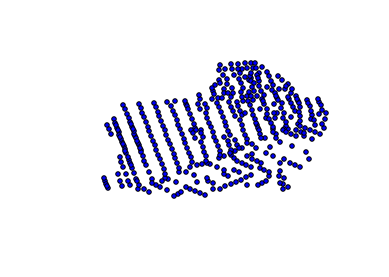

In [8]:
g0.plot(kind='scatter', x='lon', y='lat')
plt.axis('off')
plt.margins(0);

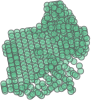

In [9]:
points = geometry.MultiPoint(zip(g0.lon, g0.lat))
points

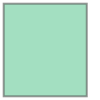

In [10]:
points.envelope

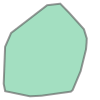

In [11]:
points.convex_hull

In [12]:
print points.convex_hull

POLYGON ((-122.4149262 37.774825, -122.4220135 37.7762879, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4220418 37.788951, -122.4203162 37.7929252, -122.4100267 37.8008532, -122.4062753 37.8012841, -122.4037825 37.7987246, -122.3995143 37.793989, -122.3987057 37.7913643, -122.3987545 37.7901007, -122.3989097 37.7882804, -122.4004581 37.7820199, -122.4027237 37.7766227, -122.4032342 37.7761656, -122.4116189 37.774997, -122.4149262 37.774825))


from http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

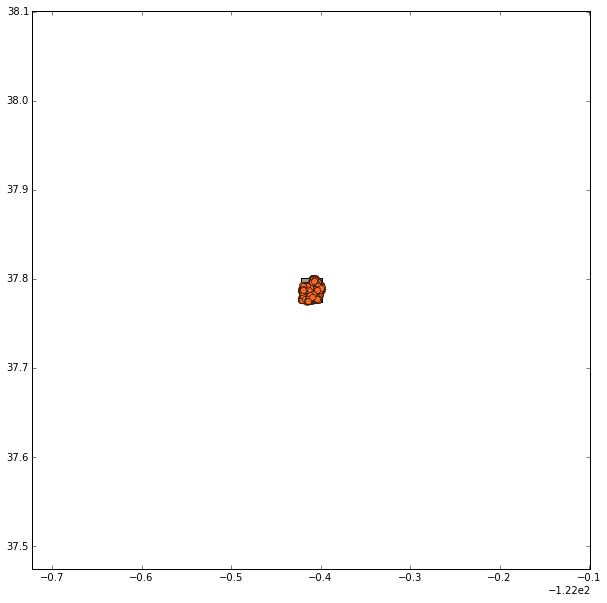

In [15]:
from descartes import PolygonPatch
 
def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
 
    x_min, y_min, x_max, y_max = polygon.bounds
 
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig
 
_ = plot_polygon(points.envelope)
_ = plt.plot(g0.lon,g0.lat,'o', color='#f16824')

In [16]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
 
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0]
                       for point in points])
 
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
 
concave_hull, edge_points = alpha_shape(points,
                                        alpha=1.87)

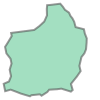

In [17]:
concave_hull, edge_points = alpha_shape(points, alpha=500)
concave_hull

In [18]:
print concave_hull

POLYGON ((-122.4027237 37.7766227, -122.4032342 37.7761656, -122.4059551 37.7770096, -122.4071553 37.7768534, -122.4094446 37.7767123, -122.4099949 37.7760366, -122.4116189 37.774997, -122.4121154 37.7753933, -122.4145362 37.7751339, -122.4149262 37.774825, -122.4175414 37.7756019, -122.4187254 37.7760734, -122.4204526 37.7767253, -122.4220135 37.7762879, -122.4221074 37.7767541, -122.4222006 37.7772211, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4209256 37.7790538, -122.4203356 37.7805572, -122.4205364 37.7814964, -122.4207265 37.7824252, -122.4201965 37.7841648, -122.4202911 37.7846322, -122.4203824 37.785096, -122.4204843 37.785564, -122.4216637 37.787081, -122.4218532 37.788019, -122.4220418 37.788951, -122.4213657 37.790001, -122.4201373 37.792044, -122.4203162 37.7929252, -122.4186681 37.7931373, -122.4170253 37.7933484, -122.415667 37.7935219, -122.4148444 37.7936274, -122.413739 37.7937713, -122.4122756 37.7948638, -122.4108545 37.796174, -122.410556 37.7968362, -122

In [19]:
from descartes import PolygonPatch

(-122.425, -122.395, 37.769999999999996, 37.805)

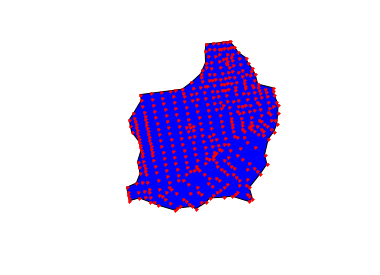

In [20]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(concave_hull, zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

In [21]:
gs = groups.group.unique()

polys = []
for g in gs:
    groupn = groups[groups.group == g]
    points = geometry.MultiPoint(zip(groupn.lon, groupn.lat))
    polygon, edge_points = alpha_shape(points, alpha=300)
    polys.append(polygon)

alpha 400 gives 'multipolygons', 300 is okay except for last one

In [22]:
polys

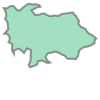

In [23]:
polys[0]

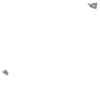

In [24]:
polys[-1]

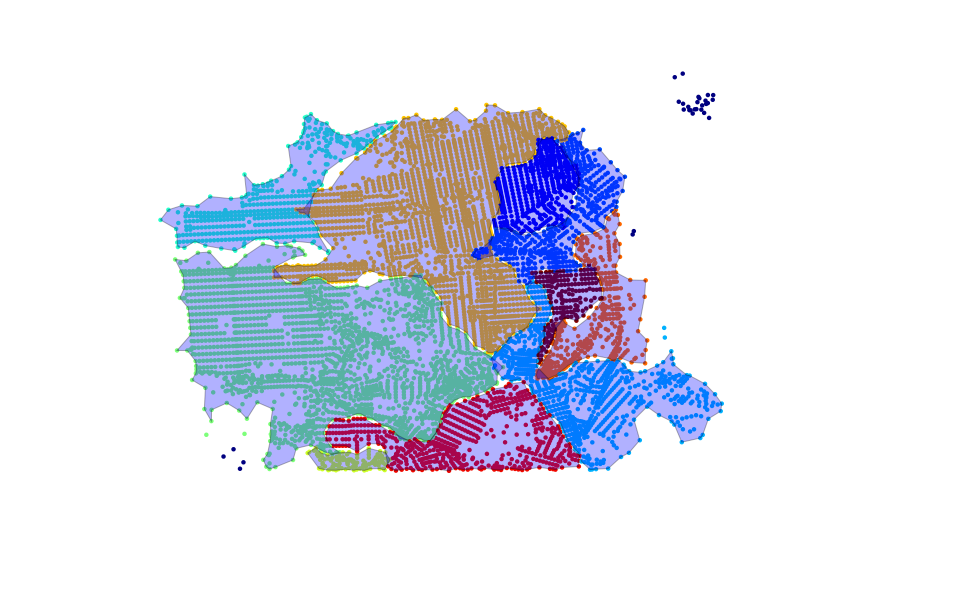

In [25]:
plt.figure(figsize=(16, 10))
plt.scatter(groups.lon, groups.lat, c=groups.group, linewidths=0)

ax = plt.gca()
for poly in polys[:-1]:
    patch = PolygonPatch(poly, zorder=1, alpha=0.3)
    ax.add_patch(patch)
plt.axis('equal')
plt.axis('off');

(-122.52, -122.38, 37.700000000000003, 37.82)

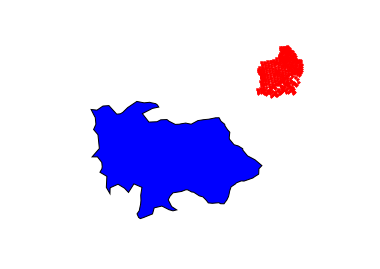

In [26]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(polys[0], zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

# Make kml file

In [27]:
from fastkml import kml

In [28]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
p = kml.Placemark(ns, 'id', 'name', 'description')
p.geometry = polys[0]
f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [29]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
for poly in polys[:-1]:
    p = kml.Placemark(ns, 'id', 'name', 'description')
    p.geometry = poly
    f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [30]:
with open('test.kml', 'wb') as f:
    f.write(k.to_string())

# GeoJSON

In [31]:
import json
import matplotlib
from shapely.geometry import mapping, shape

from code.featurize import featurizer
from code.clusterize import cut2cluster, feature_bars
from code.shapes import make_polys

In [32]:
fdf = pickle.load(open('featuresdf.pkl', 'rb'))
cnum = cut2cluster('010405', 17)

# remove nodes with no connections
fdf = fdf.ix[cnum.index]

In [33]:
df = fdf.copy()
df['cnum'] = cnum
df = df[['lat', 'lon', 'cnum']]

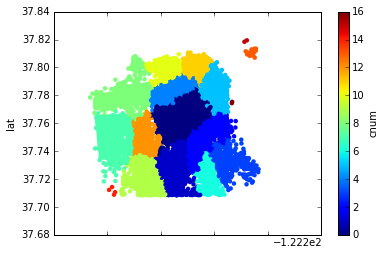

In [34]:
df.plot(kind='scatter', x='lon', y='lat', c='cnum', linewidths=0, cmap='jet')

In [35]:
polys = make_polys(df)

In [36]:
polys

In [37]:
len(polys)

17

In [38]:
jd = json.dumps(mapping(polys[0]))
print(jd)

{"type": "Polygon", "coordinates": [[[-122.4497124, 37.7386437], [-122.4511339, 37.7374936], [-122.4510653, 37.7399648], [-122.449965, 37.7422799], [-122.4493062, 37.7461032], [-122.4502214, 37.7521626], [-122.453141, 37.7531295], [-122.4543478, 37.7540775], [-122.4541041, 37.7560392], [-122.4531106, 37.7587055], [-122.4543702, 37.7613835], [-122.4571861, 37.7642874], [-122.4582901, 37.7648631], [-122.4594472, 37.7657366], [-122.4586481, 37.7666194], [-122.4569629, 37.7677016], [-122.454891, 37.769208], [-122.45378, 37.7717745], [-122.4532575, 37.7719981], [-122.4495459, 37.7720608], [-122.4464226, 37.7715089], [-122.4433158, 37.7728562], [-122.4420274, 37.7749318], [-122.4380828, 37.776388], [-122.4357807, 37.7776419], [-122.4341355, 37.7778515], [-122.4324908, 37.778061], [-122.4311415, 37.7782419], [-122.4276307, 37.7796412], [-122.4252785, 37.7799342], [-122.4229575, 37.7809491], [-122.4215388, 37.7820844], [-122.4200097, 37.7832341], [-122.4185821, 37.7843689], [-122.4167963, 37.7

In [39]:
geojson = {"type": "FeatureCollection",
           "features": [
            {"type": "Feature",
             "properties": {
                "color": "red"
            },
            "geometry": mapping(polys[0])
            }
    ]}

In [40]:
print json.dumps(geojson, indent=2, separators=(',', ': '))

{
  "type": "FeatureCollection",
  "features": [
    {
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -122.4497124,
              37.7386437
            ],
            [
              -122.4511339,
              37.7374936
            ],
            [
              -122.4510653,
              37.7399648
            ],
            [
              -122.449965,
              37.7422799
            ],
            [
              -122.4493062,
              37.7461032
            ],
            [
              -122.4502214,
              37.7521626
            ],
            [
              -122.453141,
              37.7531295
            ],
            [
              -122.4543478,
              37.7540775
            ],
            [
              -122.4541041,
              37.7560392
            ],
            [
              -122.4531106,
              37.7587055
            ],
            [
              -122.4543702,
 

In [41]:
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))

In [42]:
with open('results/geojsontest.json', 'wb') as f:
    json.dump(geojson, f)

In [43]:
c = matplotlib.cm.get_cmap('Set1')
clist = [matplotlib.colors.rgb2hex(rgb) for rgb in c(np.linspace(0,1,len(polys)))]
clist

[u'#e41a1c',
 u'#8d4c6a',
 u'#377eb8',
 u'#429780',
 u'#4eae4b',
 u'#737e77',
 u'#994fa1',
 u'#cd674f',
 u'#ff8101',
 u'#ffc11a',
 u'#fdfc33',
 u'#d1a72d',
 u'#a8572c',
 u'#d16d77',
 u'#f482be',
 u'#c58eab',
 u'#999999']

In [44]:
mapnos = ['010405' if i%2 == 0 else '010406' for i in range(len(polys)) ]
mapnos

['010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405']

In [45]:
fbars = feature_bars(fdf[['grocery', 'ncrimes', 'sgnf']], cnum)
print fbars.shape
fbars.head()

(17, 3)


,grocery,ncrimes,sgnf
cnum,,,
0,0.149822,0.041250,0.123031
1,-0.110202,-0.162532,0.268041
2,0.048199,-0.117082,0.143857
3,-0.063256,-0.101576,-0.125099
4,0.184782,0.045970,0.339135


In [46]:
fbars.ix[0].values.tolist()

[0.14982206307275842, 0.04124996513913315, 0.12303143745849965]

In [47]:
fnames = ['Grocery', 'Crime', 'Gender']

In [48]:
def list_(*args): return list(args)
map(list_, fnames, fbars.ix[0].values.tolist())

[['Grocery', 0.14982206307275842],
 ['Crime', 0.04124996513913315],
 ['Gender', 0.12303143745849965]]

In [49]:
# all polygons
featurelist = []
for i, poly in enumerate(polys):
    featurelist.append({"type": "Feature",
                        "properties": {
                        "color": clist[i],
                        "mapno": mapnos[i],
                        "neibno": i,
                        "bars" : map(list_, fnames, fbars.ix[i].values.tolist())
                        },
                        "geometry": mapping(poly)
                        })
    
geojson = {"type": "FeatureCollection",
           "features": featurelist}

In [50]:
print json.dumps(geojson, indent=2, separators=(',', ': '))

{
  "type": "FeatureCollection",
  "features": [
    {
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -122.4497124,
              37.7386437
            ],
            [
              -122.4511339,
              37.7374936
            ],
            [
              -122.4510653,
              37.7399648
            ],
            [
              -122.449965,
              37.7422799
            ],
            [
              -122.4493062,
              37.7461032
            ],
            [
              -122.4502214,
              37.7521626
            ],
            [
              -122.453141,
              37.7531295
            ],
            [
              -122.4543478,
              37.7540775
            ],
            [
              -122.4541041,
              37.7560392
            ],
            [
              -122.4531106,
              37.7587055
            ],
            [
              -122.4543702,
 

In [51]:
# human readable
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))

In [52]:
# file size reduced to ~1/3
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson))

# Voronoi

In [53]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [54]:
points = np.array((fdf.lon, fdf.lat)).T
vor = Voronoi(points)

%matplotlib notebook

In [73]:
%matplotlib inline

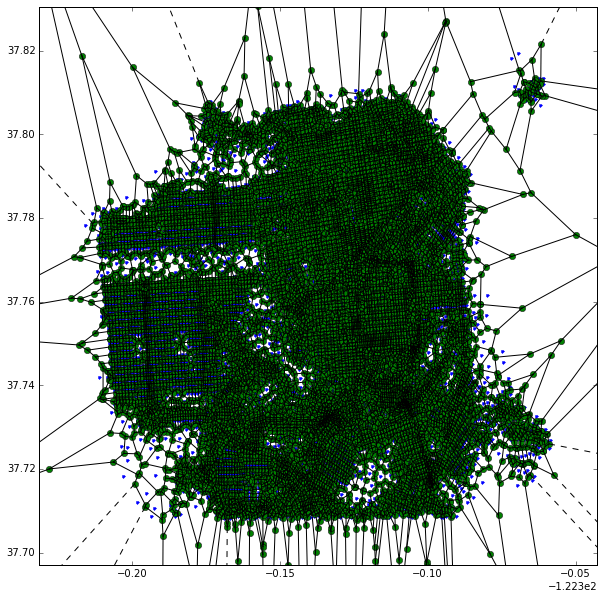

CPU times: user 55.3 s, sys: 4.29 s, total: 59.6 s
Wall time: 1min 2s


In [74]:
%%time
plt.figure(figsize=(10,10))
ax = plt.gca()
voronoi_plot_2d(vor, ax)
plt.show()

In [75]:
vor.vertices

array([[-122.35906553,   37.72598623],
       [-122.33655995,   37.77077438],
       [-122.49914235,   37.71640534],
       ..., 
       [-122.50569066,   37.75670672],
       [-122.50671114,   37.75663479],
       [-122.50676127,   37.7566594 ]])

In [76]:
np.array(vor.regions)

array([[20, 6, 5, -1, 0, 19], [24, -1, 5, 23], [37, 33, -1, 36], ...,
       [14578, 14234, 14235, 14236, 14556, 14576],
       [14579, 14268, 14420, 14423, 14234, 14578],
       [14580, 14561, 14233, 14269, 14268, 14579]], dtype=object)

In [77]:
vor.point_region

array([ 711,  678,  707, ..., 4176, 1828, 4179])

In [78]:
node = 0
verts = vor.vertices[vor.regions[vor.point_region[node]]]
verts

array([[-122.44157117,   37.74942594],
       [-122.4416337 ,   37.75051983],
       [-122.44064215,   37.75107571],
       [-122.44059616,   37.75102276],
       [-122.44050104,   37.7494826 ],
       [-122.44082679,   37.74911161],
       [-122.44111721,   37.74906621]])

* point_region - index of the region corresponding to point

In [79]:
%matplotlib inline

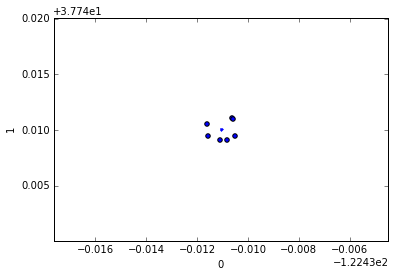

In [80]:
pd.DataFrame(verts).plot(kind='scatter', x=0, y=1)
plt.plot(df.lon[0], df.lat[0], '.')
plt.margins(0)

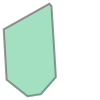

In [81]:
geometry.Polygon(verts)

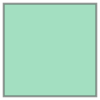

In [82]:
# test join polygons
pts1 = [[0,0], [0,1], [1,1], [1,0]]
poly1 = geometry.Polygon(pts1)
poly1

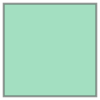

In [83]:
pts2 = [[1,0], [2,0], [2,1], [1,1]]
poly2 = geometry.Polygon(pts2)
poly2

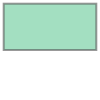

In [84]:
shapely.ops.cascaded_union([poly1, poly2])

In [85]:
polys = []
for region in vor.point_region:
    verts = vor.vertices[vor.regions[region]]
    polys.append(geometry.Polygon(verts))
    
len(polys)

7325

In [86]:
len(vor.point_region)

7325

In [108]:
parr = pd.Series(polys)
parr.shape

(7325,)

In [109]:
# remove invalid polygons
validbool = map(lambda x: x.is_valid, parr)
#parr = parr[validbool]
parr.shape

(7325,)

In [110]:
validbool = map(lambda x: x.is_valid, parr)
len(validbool)

7325

In [111]:
sum(validbool)

7313

In [112]:
# bad polygons
bp = parr[np.invert(validbool)]
bp

40      POLYGON ((-122.5123486589502 37.74679934542392...
3024    POLYGON ((-122.3969801888841 37.70910900724625...
3149    POLYGON ((-122.3918523063091 37.70905305058947...
3222    POLYGON ((-122.4175699465867 37.94332329695076...
4088    POLYGON ((-122.4750628983123 37.80697747412272...
4263    POLYGON ((-122.4502867881197 37.70924942721461...
4861    POLYGON ((-122.4954402654717 37.71132873108485...
5769    POLYGON ((-122.3641095630768 37.72080360892586...
5770    POLYGON ((-122.3020508523127 37.76960106846061...
6025    POLYGON ((-122.5604257859591 37.7115686154813,...
7167    POLYGON ((-122.4781285354225 37.65767510789367...
7209    POLYGON ((-122.5343978591963 37.85317636973765...
dtype: object

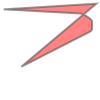

In [113]:
parr[40]

In [114]:
list(parr[40].exterior.coords)

[(-122.51234865895024, 37.746799345423916),
 (-122.51508406795023, 37.74840193271595),
 (-122.51796489382535, 37.74964129274286),
 (-122.57304118574054, 37.752629168858554),
 (-122.50676126520993, 37.756659403978475),
 (-122.56042578595914, 37.711568615481305),
 (-122.51088885592866, 37.73686005189776),
 (-122.51011486079592, 37.73780569218722),
 (-122.50979441087334, 37.73836746699593),
 (-122.50978106746224, 37.74412803664128),
 (-122.51041891023158, 37.74511989938135),
 (-122.51234865895024, 37.746799345423916)]

In [115]:
%matplotlib inline

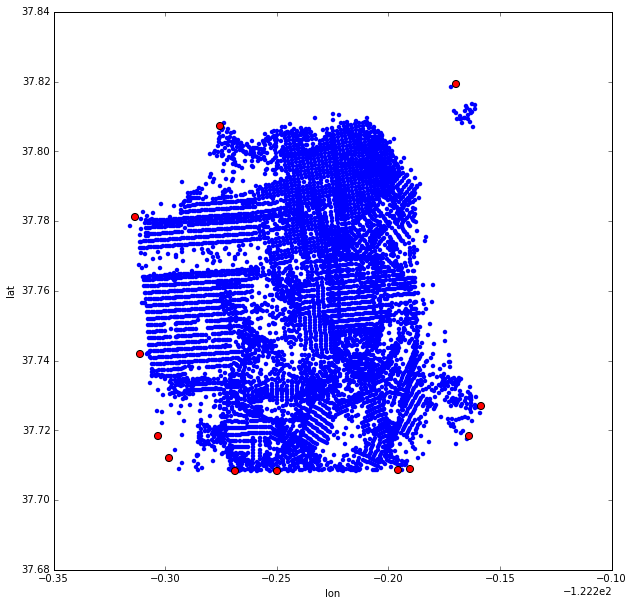

In [116]:
fdf.plot(kind='scatter', x='lon', y='lat', linewidths=0, figsize=(10,10))

for i in bp.index:
    plt.scatter(fdf.iloc[i].lon, fdf.iloc[i].lat, s=50, c='red')

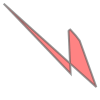

In [117]:
parr[3149]

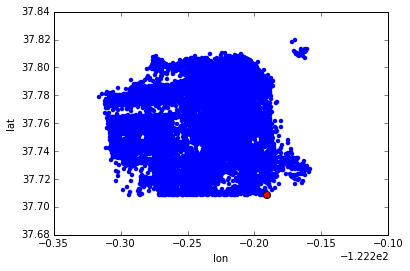

In [118]:
fdf.plot(kind='scatter', x='lon', y='lat', linewidths=0)
plt.scatter(fdf.iloc[3149].lon, fdf.iloc[3149].lat, s=50, c='red')

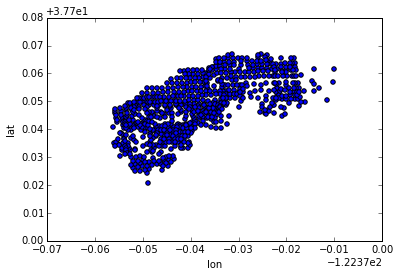

In [119]:
fdf[cnum == 2].plot(kind='scatter', x='lon', y='lat')

In [97]:
sub = parr[np.array(cnum) == 2]
print sub.shape
sub.head()

(764,)


/Users/crupley/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:216: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7313 but corresponding boolean dimension is 7325
  return self.values[slicer]
/Users/crupley/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1154: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7313 but corresponding boolean dimension is 7325
  result = getitem(key)


15    POLYGON ((-122.3884182304888 37.76178076341048...
16    POLYGON ((-122.3925838508023 37.75070323409192...
17    POLYGON ((-122.3911076616514 37.75313427996333...
18    POLYGON ((-122.3881295752724 37.74793797301871...
22    POLYGON ((-122.4104193248762 37.74111094679427...
dtype: object

In [98]:
%%time
group = shapely.ops.cascaded_union(list(sub))
group

CPU times: user 545 ms, sys: 10 ms, total: 555 ms
Wall time: 585 ms


AssertionError: 

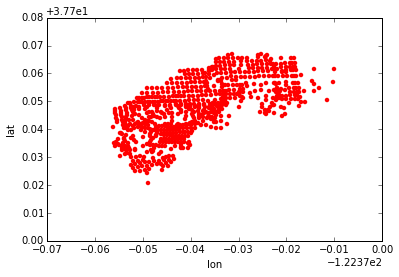

In [120]:
fdf[cnum == 2].plot(kind='scatter', x='lon', y='lat', c='red', linewidths=0)
patch = PolygonPatch(group, zorder=-1)
ax = plt.gca()
ax.add_patch(patch)

In [121]:
print cnum.shape
print len(validbool)
print parr.shape

(7325,)
7325
(7325,)


In [122]:
# group shapes into neighborhoods

# remove invalid shapes
#validbool = map(lambda x: x.is_valid, parr)
#validbool = np.ones(len(parr)).astype('bool')

neibs = []
#for c in [0,2,4,5,10,11,12,16]:
for c in cnum.unique():
    sub = parr[(np.array(cnum) == c) & (np.array(validbool))]
    print c, sub.shape
    group = shapely.ops.cascaded_union(list(sub))
    neibs.append(group)
    
len(neibs)

0 (1034,)
1 (719,)
2 (764,)
3 (436,)
4 (451,)
5 (525,)
6 (416,)
7 (645,)
8 (577,)
9 (643,)
10 (316,)
11 (386,)
12 (373,)
13 (22,)
14 (3,)
15 (1,)
16 (2,)


17

In [123]:
neibs[1] = neibs[1][1]

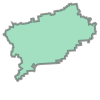

In [124]:
neibs[0]

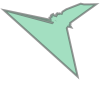

In [125]:
neibs[3]

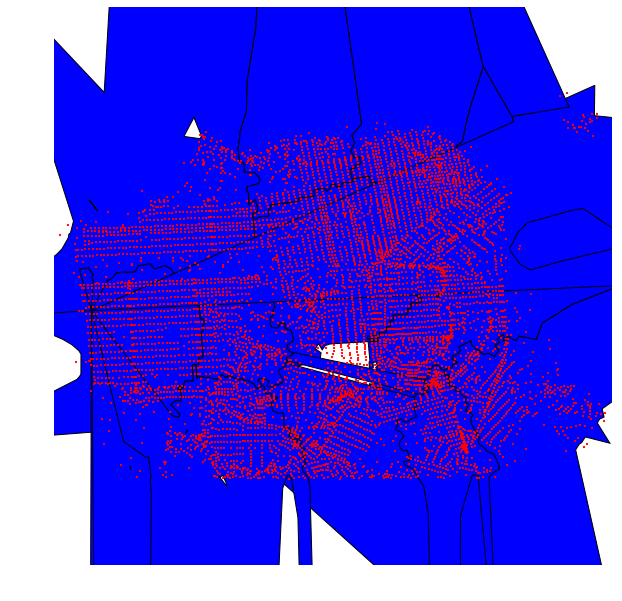

In [126]:

fdf.plot(kind='scatter', x='lon', y='lat', c='red', linewidths=0, figsize=(10,10), s=5)
plt.axis('equal')
plt.axis('off')
plt.margins(0)
ax = plt.gca()

for neib in neibs:
    patch = PolygonPatch(neib, zorder=-1, fc='blue')
    ax.add_patch(patch)

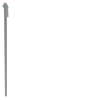

In [127]:
neibs[6]

# make more json

In [153]:
from code.shapefiles import merge_shapefiles, make_shapefiles, make_json

In [162]:
cnum = cut2cluster('010405', 17)

In [166]:
fn = 'data/uscensus/tl_2010_06075_tabblock10/tl_2010_06075_tabblock10.dbf'
mergedf = merge_shapefiles(df[['lat', 'lon']], fn)
polys = make_shapefiles(df[['lat', 'lon']], mergedf.polys, cnum)

In [167]:
jsn = make_json(polys, clist, mapnos, fnames, fbars)

In [168]:
# file size reduced to ~1/3
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(jsn))

In [159]:
cnum.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [169]:
fbars

,grocery,ncrimes,sgnf
cnum,,,
0,0.149822,0.041250,0.123031
1,-0.110202,-0.162532,0.268041
2,0.048199,-0.117082,0.143857
3,-0.063256,-0.101576,-0.125099
4,0.184782,0.045970,0.339135
5,0.655732,0.415184,-0.120709
6,0.030552,-0.158924,0.052501
7,-0.133794,-0.207972,0.291413
8,-0.075690,-0.180200,0.183397


# multimap

In [231]:
from code.clusterize import *

In [171]:
cnum = cut2cluster('010405', 25)

In [172]:
polys = make_shapefiles(df[['lat', 'lon']], mergedf.polys, cnum)

In [180]:
clist = gencolors(25)

In [182]:
mapno = '010405'

In [186]:
fdf.shape

(7325, 11)

In [187]:
fbars = feature_bars(fdf[['grocery', 'ncrimes', 'sgnf']], cnum)

In [ ]:
fbars

In [190]:
print len(cnum)
print len(polys)
print len(clist)
print len(fbars)

7325
25
25
25


In [218]:
bigdf = pd.DataFrame({'cnum': cnum.unique(),
                      'polygon': polys})
bigdf['color'] = clist
bigdf['mapno'] = '010405'
bigdf['fbars'] = map(list, fbars.round(2).values)
print bigdf.shape
bigdf.head()

(25, 5)


,cnum,polygon,color,mapno,fbars
0,0,"(POLYGON ((-122.446195 37.741872, -122.446157 ...",#e41a1c,010405,"[0.16, 0.01, 0.25]"
1,1,"POLYGON ((-122.444987 37.748008, -122.445957 3...",#ae394d,010405,"[0.13, 0.02, 0.13]"
2,2,(POLYGON ((-122.425880185202 37.73290659738661...,#725c83,010405,"[-0.08, -0.12, 0.22]"
3,3,(POLYGON ((-122.3939987500847 37.7453566405468...,#377eb8,010405,"[-0.03, -0.1, -0.17]"
4,4,"(POLYGON ((-122.404258 37.738713, -122.404277 ...",#3e8e95,010405,"[-0.05, -0.06, -0.15]"


In [221]:
s = '010405'

In [223]:
list(s)

['0', '1', '0', '4', '0', '5']

In [229]:
[s[i-1] + s[i] for i in range(len(s)) if i%2 == 0]
n = [int(s[i] + s[i+1]) for i in range(len(s)) if i%2 == 0]
n

[1, 4, 5]

In [230]:
tuple(n)

(1, 4, 5)

In [233]:
mapno2list('010405')

[1, 4, 5]

In [235]:
list2mapno([1,4,5])

'010405'